# Predicting Mortality Challenge 
The Vertex team provided the following question to answer:

The PhysioNet Challenge 2012 dataset (Silva et al., 2012) is a collection of multivariate clinical time-series data from 4000 intensive care patient records, publicly available at https://physionet.org/challenge/2012/. Each record is a time series of roughly 48 hours and contains 37 variables such as pH, heart rate, and glucose level. Set A and the associated outcomes are attached to this email. Only using the provided dataset, predict whether a patient will die in the hospital.

Based on the above challenge and a further reading of the PsioNet challenge, please note the following assumptions:

* All data is collected during the first 48 hours of admission
* All patients survivied the first 48 hours of admission and those who died did so during thier hospital stay 
* The only variable from the outcome-related descriptors that will be used is `in-hosptial death`.  All other variables cannot be use for prediction
* There is no indication that there are any variables in the file `seta_data.csv` that would not be available when the model would need to be run, and there is no risk of [target leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning))

Please note the following:

* After pulling the repository unzip the file `DSS_data.zip`.  It will create the subfolder `DSS_data\` and the notebook should be able to run as is.

## Setup
Below are the packages that need to be imported for this challenge

In [1]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

from sklearn.calibration import CalibrationDisplay

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

# Import Data
This section imports all of the necessary data for thhis project


## tgt_df
Import the file `Outcomes-a.txt`, and rename it tgt_df (target), and clean up the variables to make them easier for downstream usage.  After review please note the following:

* There are 4000 patients and no duplicate ids.  It's safe to make the id the index
* 13.9% of the population died during their hospital stay.  In my expeience with data at MGH this is in line with what should be expected for patients who are admitted to the ICU
* Given that there are ~554 patients who perished and logistic regression will be used to develop a model with a 20% holdout, it's safe to say that approximately 40 features could be created without too much of a risk for overfitting.
  * After the group is split features will be created for both populations; however, when exploring the data only the training group will be used to look at summary statistic.  This is to ensure that the 20% testing set is a true holdout.

In [2]:
# Import file and clean up columns
tgt_df = pd.read_csv("DSS_data/Outcomes-a.txt")
tgt_df.columns = tgt_df.columns.str.lower()
tgt_df = tgt_df[['recordid','in-hospital_death']]
tgt_df.columns = ['id','death']

# Review summary statistics
len(tgt_df)
tgt_df.index.nunique()
tgt_df.dtypes
tgt_df.death.sum()

# Set index for easier joins
tgt_df.set_index('id', inplace=True)

4000

4000

id       int64
death    int64
dtype: object

554

In [3]:
# Split into training and testing and confirm that the counts look correct
train, test = train_test_split(tgt_df, test_size=0.2, random_state=5)
train['group'] = 'train'
test['group'] = 'test'
tgt_df = pd.concat([train,test])
del train, test
len(tgt_df)
tgt_df.index.nunique()
tgt_df.head(3)


4000

4000

death  group
id                  
140292      0  train
136392      0  train
139169      1  train

## seta_df
Import the time series measurements and clean them up for later use

In [4]:
# Import data and clean columns
seta_df = pd.read_csv("DSS_data/seta_data.csv",
                      dtype={'PATIENT_ID':int,
                             'Parameter':object,
                             'Time':object,
                             'Value':'float64'})
seta_df.columns = ['id','param','time', 'value']
seta_df['hour'] = seta_df['time'].str.slice(0,2).astype(int)
seta_df['param'] = seta_df['param'].str.lower()

# Review summary stats of the data
seta_df.head(3)
seta_df.dtypes
len(seta_df)
seta_df.nunique()

# Set id to index
seta_df.set_index('id', inplace=True)

id     param   time     value  hour
0  132539  recordid  00:00  132539.0     0
1  132539       age  00:00      54.0     0
2  132539    gender  00:00       0.0     0

id         int64
param     object
time      object
value    float64
hour       int64
dtype: object

1757980

id       4000
param      42
time     2881
value    7579
hour       49
dtype: int64

In [5]:
# Confirm there are no null values
seta_df['param'].isnull().sum()
seta_df['time'].isnull().sum()
seta_df['value'].isnull().sum()

0

0

0

In [6]:
# Review basic stats of 
(seta_df[['param','value']]
 .groupby('param')
 .agg(['mean','median','min','max']))

value                                 
                      mean     median        min        max
param                                                      
age              64.247500      67.00      15.00      90.00
albumin           2.922326       2.90       1.00       5.30
alp             116.773286      82.00      12.00    2205.00
alt             394.474976      43.00       1.00   11470.00
ast             506.284098      64.00       4.00   18430.00
bilirubin         2.908555       0.90       0.10      47.70
bun              27.416528      20.00       0.00     197.00
cholesterol     156.517460     152.00      28.00     330.00
creatinine        1.504977       1.00       0.10      22.10
diasabp          59.290512      58.00       0.00     268.00
fio2              0.545201       0.50       0.21       1.00
gcs              11.398714      13.00       3.00      15.00
gender            0.560750       1.00      -1.00       1.00
glucose         141.509561     127.00      10.00    1143.00
hco3             23.115742      23.00       5.00      50.00
hct              30.679043      30.30       9.00      61.80
height           88.919475     152.40      -1.00     431.80
hr               87.517442      86.00       0.00     300.00
icutype           2.760000       3.00       1.00       4.00
k                 4.136219       4.10       1.80      22.90
lactate           2.924779       2.10       0.30      29.30
map              79.742927      77.00       0.00     300.00
mechvent          1.000000       1.00       1.00       1.00
mg                2.027910       2.00       0.60       9.90
na              139.075829     139.00      98.00     177.00
nidiasabp        57.953864      56.00       0.00     201.00
nimap            76.780450      75.00       0.00     209.00
nisysabp        118.594024     116.00       0.00     296.00
paco2            40.474748      39.00       0.30     100.00
pao2            150.415269     121.00       0.00     500.00
ph                7.489200       7.38       1.00     735.00
platelets       190.815719     172.00       6.00    1047.00
recordid     137605.122000  137592.50  132539.00  142673.00
resprate         19.723729      19.00       0.00      98.00
sao2             96.637068      97.00      26.00     100.00
sysabp          118.697899     116.00       0.00     295.00
temp             37.007651      37.10     -17.80      42.10
troponini         7.151264       2.60       0.30      49.20
troponint         1.198451       0.20       0.01      24.91
urine           120.798728      70.00       0.00   11000.00
wbc              12.670084      11.40       0.10     187.50
weight           83.386615      80.60      -1.00     300.00

## labs_df
The 37 time series measures are split out into a separate dataframe because the logic needed to treat them is different from the measure that are no time series.  This will make downstream programming easier.

In [7]:
# Confirm the 37 measures are identified
admit_measures = ['age','icutype','height','gender','recordid']
labs_df = seta_df.loc[~seta_df['param'].isin(admit_measures)]
labs_df['day'] = np.where(labs_df.hour < 24,1,2)
labs_df = labs_df.join(tgt_df)
labs_df.param.nunique()
labs_df.head(3)
labs_df.loc[(labs_df['day'] ==2) & (labs_df['param'] == 'temp')].head()

37

param   time  value  hour  day  death group
id                                                  
132539  weight  00:00   -1.0     0    1      0  test
132539     gcs  00:07   15.0     0    1      0  test
132539      hr  00:07   73.0     0    1      0  test

param   time  value  hour  day  death group
id                                                
132539  temp  27:37   37.9    27    2      0  test
132539  temp  31:37   38.1    31    2      0  test
132539  temp  35:37   38.2    35    2      0  test
132539  temp  39:37   37.9    39    2      0  test
132539  temp  43:37   37.6    43    2      0  test

In [8]:
# Review remaining measurements for clues
(labs_df.reset_index()[['param','value','id','hour']]
 .groupby('param')
 .agg(['count','nunique','min','median','max'])
 .sort_values(by = [('id','count')], ascending=False))

value                                       id                  \
              count nunique    min  median       max   count nunique     min   
param                                                                          
hr           228538     193   0.00   86.00    300.00  228538    3937  132539   
map          145760     288   0.00   77.00    300.00  145760    2792  132540   
sysabp       145650     238   0.00  116.00    295.00  145650    2799  132540   
diasabp      145567     169   0.00   58.00    268.00  145567    2799  132540   
urine        136918     553   0.00   70.00  11000.00  136918    3883  132539   
weight       129165     996  -1.00   80.60    300.00  129165    4000  132539   
nisysabp      98331     212   0.00  116.00    296.00   98331    3493  132539   
nidiasabp     98210     154   0.00   56.00    201.00   98210    3483  132539   
nimap         96871     409   0.00   75.00    209.00   96871    3481  132539   
temp          86405     137 -17.80   37.10     42.10   86405    3936  132539   
gcs           61563      13   3.00   13.00     15.00   61563    3936  132539   
resprate      55051      64   0.00   19.00     98.00   55051    1101  132539   
fio2          32390      37   0.21    0.50      1.00   32390    2717  132540   
mechvent      31144       1   1.00    1.00      1.00   31144    2529  132540   
ph            24355      91   1.00    7.38    735.00   24355    3040  132540   
paco2         23293      90   0.30   39.00    100.00   23293    3023  132540   
pao2          23268     480   0.00  121.00    500.00   23268    3023  132540   
hct           18271     368   9.00   30.30     61.80   18271    3936  132539   
k             14440      80   1.80    4.10     22.90   14440    3904  132539   
platelets     14104     640   6.00  172.00   1047.00   14104    3932  132539   
creatinine    13983     145   0.10    1.00     22.10   13983    3936  132539   
bun           13916     173   0.00   20.00    197.00   13916    3936  132539   
hco3          13613      44   5.00   23.00     50.00   13613    3924  132539   
mg            13590      51   0.60    2.00      9.90   13590    3897  132539   
na            13570      73  98.00  139.00    177.00   13570    3925  132539   
glucose       13021     471  10.00  127.00   1143.00   13021    3887  132539   
wbc           12910     455   0.10   11.40    187.50   12910    3927  132539   
sao2           8185      47  26.00   97.00    100.00    8185    1792  132540   
lactate        8024     201   0.30    2.10     29.30    8024    2183  132541   
bilirubin      3191     243   0.10    0.90     47.70    3191    1718  132541   
ast            3182     812   4.00   64.00  18430.00    3182    1725  132541   
alt            3177     753   1.00   43.00  11470.00    3177    1721  132541   
alp            3092     387  12.00   82.00   2205.00    3092    1690  132541   
albumin        2356      41   1.00    2.90      5.30    2356    1615  132541   
troponint      2126     451   0.01    0.20     24.91    2126     863  132584   
troponini       435     163   0.30    2.60     49.20     435     205  132547   
cholesterol     315     140  28.00  152.00    330.00     315     305  132547   

                                 hour                         
               median     max   count nunique min median max  
param                                                         
hr           137600.0  142673  228538      49   0   21.0  48  
map          137679.0  142673  145760      49   0   21.0  48  
sysabp       137678.0  142673  145650      49   0   21.0  48  
diasabp      137678.0  142673  145567      49   0   21.0  48  
urine        137600.0  142673  136918      49   0   23.0  48  
weight       137487.0  142673  129165      49   0   24.0  48  
nisysabp     137556.0  142673   98331      49   0   21.0  48  
nidiasabp    137556.0  142673   98210      49   0   21.0  48  
nimap        137556.0  142673   96871      49   0   21.0  48  
temp         137699.0  142673   86405      49   0   20.0 

# Explore
Explore the data features

## Var, Time, Death
Create Visualizations to understand the relationship between teh variable time and death.

In [9]:
# Create simple visualization of deaths
def var_time_death(df, var):
    agg_df = (df.loc[(labs_df['param'] == var),
                     ['hour','value','group','death']]
              .groupby(['group','hour','id'])
              .agg('mean')
              .reset_index())
    agg_df['color'] = np.where(agg_df.death == 1,'r','b')
    return sns.lineplot(data=agg_df, x="hour", y="value", hue="death").set(title=var)

In [10]:
# Identify all unique tests to copy into the graphs
np.sort(labs_df.param.unique())

array(['albumin', 'alp', 'alt', 'ast', 'bilirubin', 'bun', 'cholesterol',
       'creatinine', 'diasabp', 'fio2', 'gcs', 'glucose', 'hco3', 'hct',
       'hr', 'k', 'lactate', 'map', 'mechvent', 'mg', 'na', 'nidiasabp',
       'nimap', 'nisysabp', 'paco2', 'pao2', 'ph', 'platelets',
       'resprate', 'sao2', 'sysabp', 'temp', 'troponini', 'troponint',
       'urine', 'wbc', 'weight'], dtype=object)

### albumin

[Text(0.5, 1.0, 'albumin')]

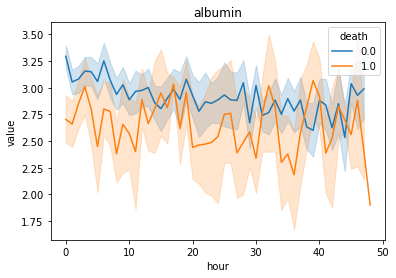

In [11]:
var_time_death(labs_df,'albumin')

### alp

[Text(0.5, 1.0, 'alp')]

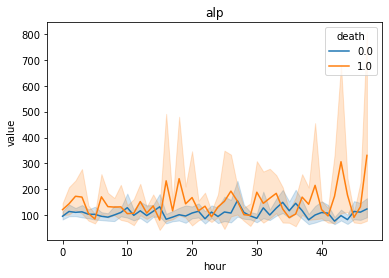

In [12]:
var_time_death(labs_df,'alp')

### alt

[Text(0.5, 1.0, 'alt')]

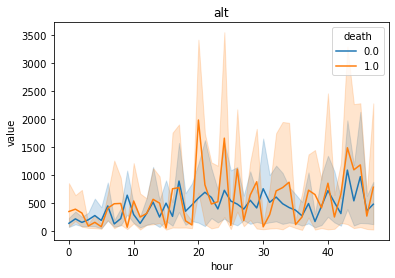

In [13]:
var_time_death(labs_df,'alt')

### ast

[Text(0.5, 1.0, 'ast')]

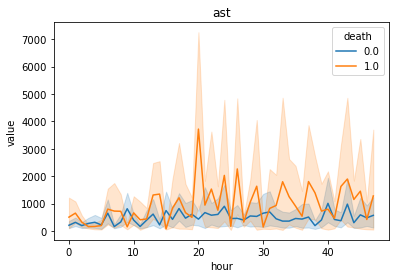

In [14]:
var_time_death(labs_df,'ast')

### bilirubin

[Text(0.5, 1.0, 'bilirubin')]

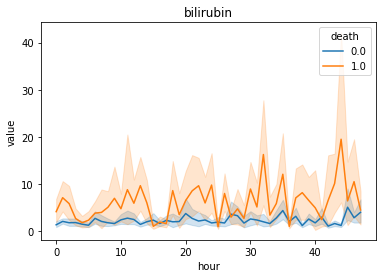

In [15]:
var_time_death(labs_df,'bilirubin')

### bun *
Those that died tended to have higher billirubin.  Using the distance from the overall median to the patients median should be good enough

[Text(0.5, 1.0, 'bun')]

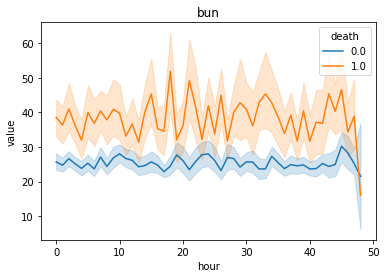

In [16]:
var_time_death(labs_df,'bun')

### cholesterol

[Text(0.5, 1.0, 'cholesterol')]

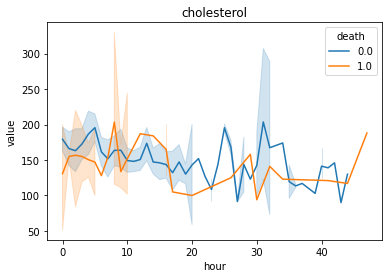

In [17]:
var_time_death(labs_df,'cholesterol')

### creatinine

[Text(0.5, 1.0, 'creatinine')]

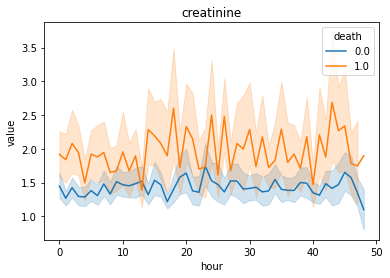

In [18]:
var_time_death(labs_df,'creatinine')

### diasabp

[Text(0.5, 1.0, 'diasabp')]

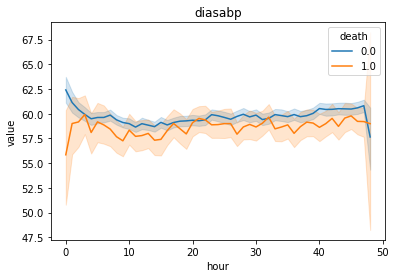

In [19]:
var_time_death(labs_df,'diasabp')

### fio2

[Text(0.5, 1.0, 'fio2')]

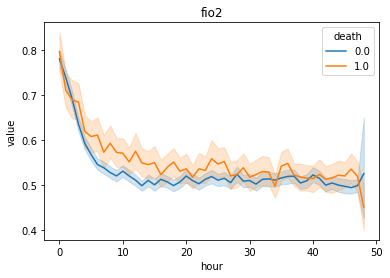

In [20]:
var_time_death(labs_df,'fio2')

### gcs*
Min Day 1 to max Day 2

[Text(0.5, 1.0, 'gcs')]

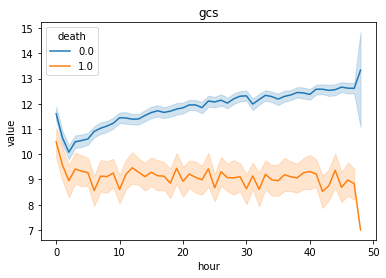

In [21]:
var_time_death(labs_df,'gcs')

### glucose

[Text(0.5, 1.0, 'glucose')]

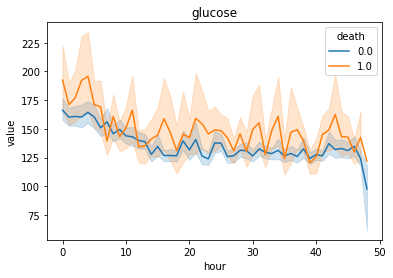

In [22]:
var_time_death(labs_df,'glucose')

### hco3

[Text(0.5, 1.0, 'hco3')]

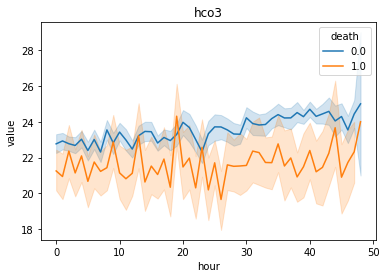

In [23]:
var_time_death(labs_df,'hco3')

### hct

[Text(0.5, 1.0, 'hct')]

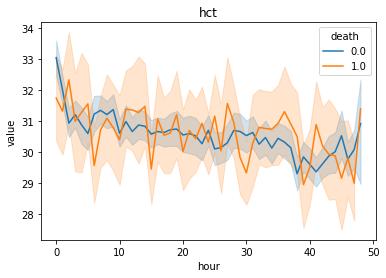

In [24]:
var_time_death(labs_df,'hct')

### hr

[Text(0.5, 1.0, 'hr')]

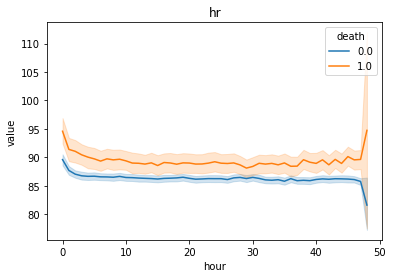

In [25]:
var_time_death(labs_df,'hr')

### k

[Text(0.5, 1.0, 'k')]

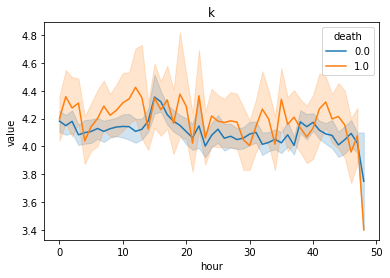

In [26]:
var_time_death(labs_df,'k')

### lactate*
Day 2 median from median

[Text(0.5, 1.0, 'lactate')]

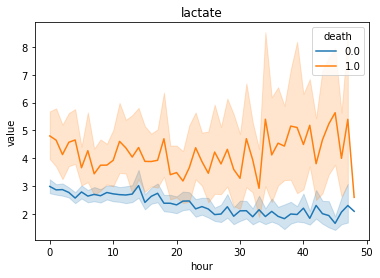

In [27]:
var_time_death(labs_df,'lactate')

### map

[Text(0.5, 1.0, 'map')]

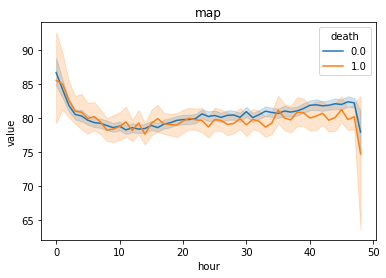

In [28]:
var_time_death(labs_df,'map')

### mechvent

[Text(0.5, 1.0, 'mechvent')]

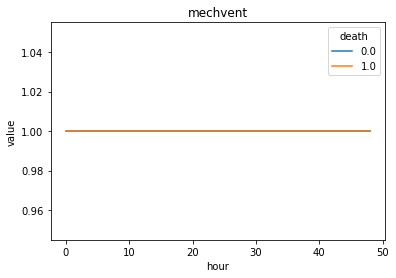

In [29]:
var_time_death(labs_df,'mechvent')

### mg

[Text(0.5, 1.0, 'mg')]

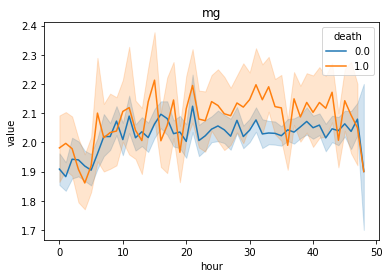

In [30]:
var_time_death(labs_df,'mg')

### na

[Text(0.5, 1.0, 'na')]

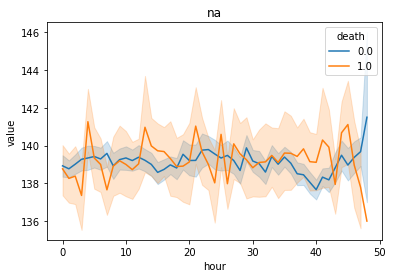

In [31]:
var_time_death(labs_df,'na')

### nidiasabp*
Patient median from overall median

[Text(0.5, 1.0, 'nidiasabp')]

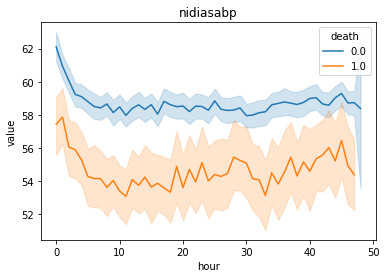

In [32]:
var_time_death(labs_df,'nidiasabp')

### nimap

[Text(0.5, 1.0, 'nimap')]

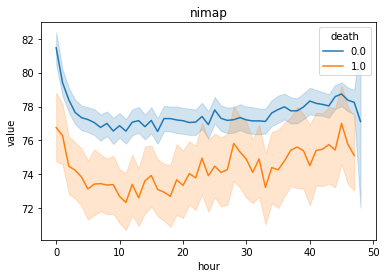

In [33]:
var_time_death(labs_df,'nimap')

### nisysabp

[Text(0.5, 1.0, 'nisysabp')]

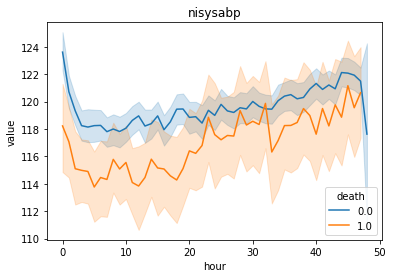

In [34]:
var_time_death(labs_df,'nisysabp')

### paco2

[Text(0.5, 1.0, 'paco2')]

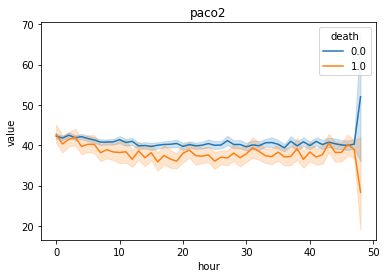

In [35]:
var_time_death(labs_df,'paco2')

### pao2

[Text(0.5, 1.0, 'pao2')]

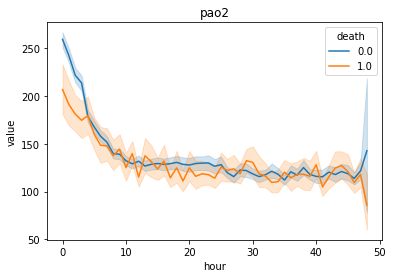

In [36]:
var_time_death(labs_df,'pao2')

### ph

[Text(0.5, 1.0, 'ph')]

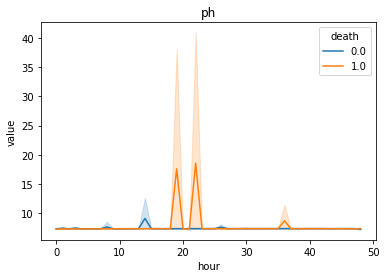

In [37]:
var_time_death(labs_df,'ph')

### platelets

[Text(0.5, 1.0, 'platelets')]

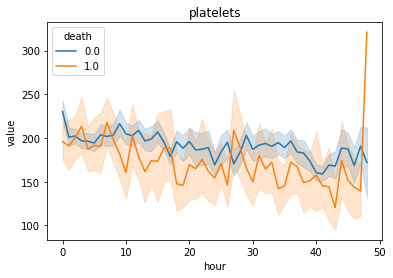

In [38]:
var_time_death(labs_df,'platelets')

### resprate

[Text(0.5, 1.0, 'resprate')]

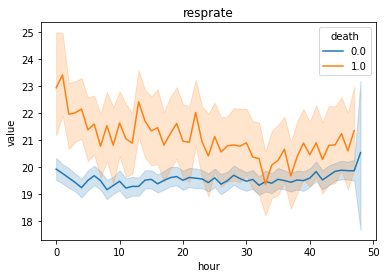

In [39]:
var_time_death(labs_df,'resprate')

### sao2

[Text(0.5, 1.0, 'sao2')]

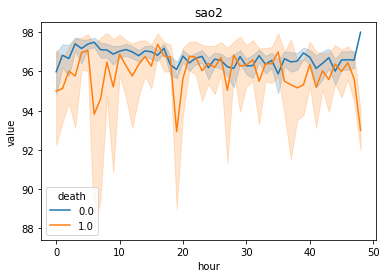

In [40]:
var_time_death(labs_df,'sao2')

### sysabp

[Text(0.5, 1.0, 'sysabp')]

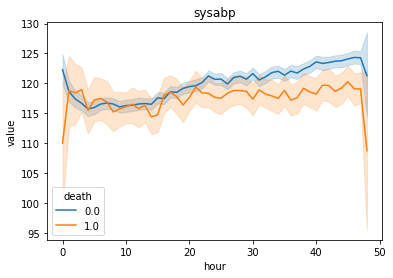

In [41]:
var_time_death(labs_df,'sysabp')

### temp*
Day 2: median from median

[Text(0.5, 1.0, 'temp')]

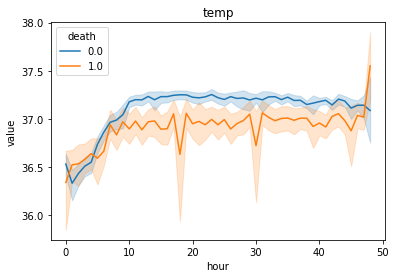

In [42]:
var_time_death(labs_df,'temp')

### troponini

[Text(0.5, 1.0, 'troponini')]

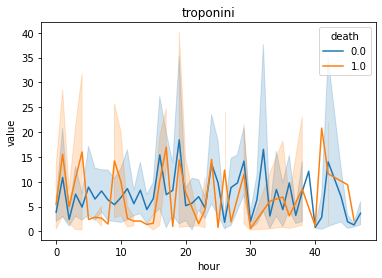

In [43]:
var_time_death(labs_df,'troponini')

### troponint

[Text(0.5, 1.0, 'troponint')]

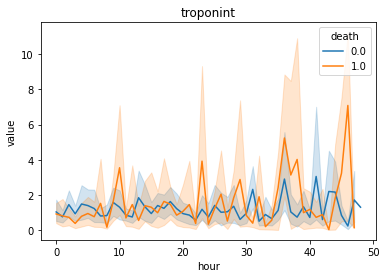

In [44]:
var_time_death(labs_df,'troponint')

### urine

[Text(0.5, 1.0, 'urine')]

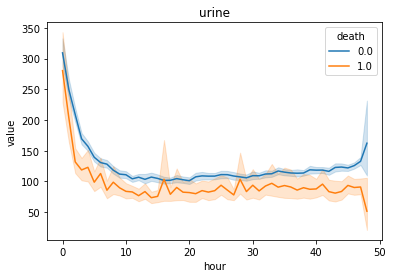

In [45]:
var_time_death(labs_df,'urine')

### wbc

[Text(0.5, 1.0, 'wbc')]

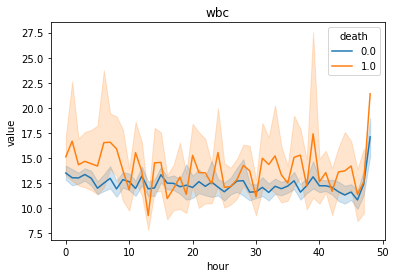

In [46]:
var_time_death(labs_df,'wbc')

### weight

[Text(0.5, 1.0, 'weight')]

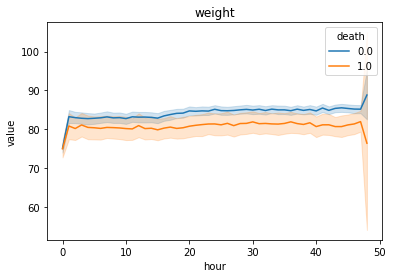

In [47]:
var_time_death(labs_df,'weight')

## labs_death_df
It's very possible that just the existance of certain labs may be a predictor for survival.

In [48]:
labs_pre_pivot = labs_df[['param']].reset_index().drop_duplicates()
labs_pre_pivot['exists'] = 1
labs_pivot = labs_pre_pivot.pivot(index='id',columns='param', values = 'exists')
labs_death_df = tgt_df.loc[tgt_df.group == 'train',['death']].join(labs_pivot).fillna(0)
labs_death_df.head()

death  albumin  alp  alt  ast  bilirubin  bun  cholesterol  \
id                                                                   
140292      0      1.0  1.0  1.0  1.0        1.0  1.0          0.0   
136392      0      0.0  0.0  0.0  0.0        0.0  1.0          0.0   
139169      1      1.0  1.0  1.0  1.0        1.0  1.0          0.0   
139665      0      0.0  0.0  0.0  0.0        0.0  1.0          1.0   
136178      0      0.0  1.0  1.0  1.0        1.0  1.0          1.0   

        creatinine  diasabp  ...  platelets  resprate  sao2  sysabp  temp  \
id                           ...                                            
140292         1.0      1.0  ...        1.0       0.0   1.0     1.0   1.0   
136392         1.0      1.0  ...        1.0       0.0   1.0     1.0   1.0   
139169         1.0      1.0  ...        1.0       0.0   1.0     1.0   1.0   
139665         1.0      1.0  ...        1.0       1.0   0.0     1.0   1.0   
136178         1.0      1.0  ...        1.0       1.0   0.0     1.0   1.0   

        troponini  troponint  urine  wbc  weight  
id                                                
140292        0.0        0.0    1.0  1.0     1.0  
136392        0.0        0.0    1.0  1.0     1.0  
139169        0.0        0.0    1.0  1.0     1.0  
139665        0.0        0.0    1.0  1.0     1.0  
136178        0.0        0.0    1.0  1.0     1.0  

[5 rows x 38 columns]

In [49]:
lab_delta_df = pd.DataFrame(columns=['lab', 'has_lab_mean', 'has_lab_count', 'no_lab_mean', 'no_lab_count',
       'lab_mean_delta'])

for param in labs_pre_pivot.param.unique():
    df = labs_death_df[['death',param]].reset_index().groupby(param).agg({'death':['mean','count']})
    df['lab'] = df.index.name
    df.reset_index(inplace=True)
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.columns =['has_lab','mean','count','lab']
    df = df[['lab','has_lab','mean', 'count']]

    df_has_lab = df[df.has_lab == 1]
    df_has_lab.columns = ['lab','has_lab','has_lab_mean','has_lab_count']
    df_no_lab  = df[df.has_lab == 0]
    df_no_lab.columns = ['lab','no_lab','no_lab_mean','no_lab_count']
    df_has_lab.reset_index(inplace=True)
    df_no_lab.reset_index(inplace=True)

    lab_comp_df = df_has_lab.join(df_no_lab[['no_lab_mean','no_lab_count']])
    lab_comp_df = lab_comp_df[['lab', 'has_lab_mean', 'has_lab_count','no_lab_mean', 'no_lab_count']]
    lab_comp_df['lab_mean_delta'] = lab_comp_df['has_lab_mean'] - lab_comp_df['no_lab_mean']
    lab_delta_df = pd.concat([lab_delta_df, lab_comp_df])

### Lab Table

In [50]:
lab_delta_df.sort_values('lab_mean_delta', ascending=False)

lab has_lab_mean has_lab_count no_lab_mean no_lab_count  \
0    troponini     0.277108           166    0.127554         3034   
0    troponint     0.215007           693    0.113283         2507   
0          wbc     0.137087          3144    0.035714           56   
0    platelets     0.136999          3146    0.037037           54   
0          hct     0.136869          3149    0.039216           51   
0          bun     0.136782          3151    0.040816           49   
0   creatinine     0.136782          3151    0.040816           49   
0      glucose     0.137765          3114    0.046512           86   
0          alt     0.183792          1382     0.09846         1818   
0          ast     0.183394          1385    0.098623         1815   
0          alp     0.184094          1358    0.099349         1842   
0         hco3     0.136812          3143    0.052632           57   
0    bilirubin     0.182865          1389     0.09884         1811   
0            k     0.137148          3128    0.055556           72   
0      albumin     0.181126          1314    0.103393         1886   
0      lactate     0.169511          1758     0.09362         1442   
0           mg     0.137223          3119    0.061728           81   
0         fio2       0.1593          2172     0.08463         1028   
0        paco2     0.151804          2411    0.084918          789   
0         pao2     0.151389          2411    0.086185          789   
0           na      0.13645          3144    0.071429           56   
0           ph      0.15099          2424     0.08634          776   
0           hr     0.136003          3147     0.09434           53   
0         temp     0.136003          3147     0.09434           53   
0          gcs     0.136003          3147     0.09434           53   
0     mechvent     0.149852          2022    0.110357         1178   
0  cholesterol     0.154167           240    0.133784         2960   
0         sao2      0.14446          1426    0.127959         1774   
0        nimap     0.136722          2794    0.125616          406   
0      diasabp     0.138713          2206    0.127767          994   
0       sysabp     0.138713          2206    0.127767          994   
0    nidiasabp     0.136624          2796    0.126238          404   
0          map     0.138056          2202    0.129259          998   
0     nisysabp     0.136234          2804    0.128788          396   
0        urine     0.134708          3103    0.154639           97   
0     resprate     0.077449           878    0.157192         2322   
0       weight     0.135313          3200         NaN          NaN   

  lab_mean_delta  
0       0.149554  
0       0.101724  
0       0.101372  
0       0.099962  
0       0.097653  
0       0.095966  
0       0.095966  
0       0.091253  
0       0.085332  
0       0.084771  
0       0.084746  
0        0.08418  
0       0.084025  
0       0.081593  
0       0.077733  
0       0.075891  
0       0.075495  
0        0.07467  
0       0.066887  
0       0.065204  
0       0.065022  
0        0.06465  
0       0.041663  
0       0.041663  
0       0.041663  
0       0.039495  
0       0.020383  
0       0.016501  
0       0.011106  
0       0.010946  
0       0.010946  
0       0.010386  
0       0.008798  
0       0.007446  
0      -0.019931  
0      -0.079743  
0            NaN

# Raw Features
Create raw features that will be later treated for modeling

## admit_df
Identify the key values upon admission that are not part of the time series, and only exist once per admission.  The data is pivoted to created `admit_df`, and confirmed that exactly 4,000 rows of unique measures remain.

In [51]:
# Pivot Measures
admit_measures = ['age','icutype','height','gender']
admit_df = (seta_df.loc[(seta_df['time'] == '00:00') &
                        (seta_df['param'].isin(admit_measures))]
            .reset_index()
            .pivot('id','param','value'))

# Review stats
len(admit_df)
admit_df.index.nunique()
admit_df.head(3)

4000

4000

param    age  gender  height  icutype
id                                   
132539  54.0     0.0    -1.0      4.0
132540  76.0     1.0   175.3      2.0
132541  44.0     0.0    -1.0      3.0

## has_lab_df
Identification of labs that the patient received in the ICU that appear to be of interest

In [52]:
lab_list = ['troponini','troponint','alt','albumin','paco2','resprate','gcs']
has_lab_df = labs_df.loc[labs_df['param'].isin(lab_list),['param']].reset_index().drop_duplicates()
has_lab_df['exists'] = 1
has_lab_df = has_lab_df.pivot(index='id',columns='param', values = 'exists').fillna(0)
len(has_lab_df)
has_lab_df.index.nunique()
has_lab_df.columns = ["has_" + x for x in has_lab_df.columns]
has_lab_df.head()

3983

3983

has_albumin  has_alt  has_gcs  has_paco2  has_resprate  has_troponini  \
id                                                                              
132539          0.0      0.0      1.0        0.0           1.0            0.0   
132540          0.0      0.0      1.0        1.0           0.0            0.0   
132541          1.0      1.0      1.0        1.0           0.0            0.0   
132543          1.0      1.0      1.0        0.0           1.0            0.0   
132545          1.0      0.0      1.0        0.0           1.0            0.0   

        has_troponint  
id                     
132539            0.0  
132540            0.0  
132541            0.0  
132543            0.0  
132545            0.0

## median_delta_df
Identify distance from the median value of a lab for each patient

* bun
* nidiasabp
* lactate: Day 2 median
* temp: Day 2 median

In [53]:
labs_df.loc[labs_df.param.isin(['lactate','temp']) & labs_df.day == 2]

Empty DataFrame
Columns: [param, time, value, hour, day, death, group]
Index: []

In [54]:
# Overall median value for each
labs_median_df = (labs_df
                  .loc[(labs_df.param.isin(['bun','nidiasabp'])) |
                       (labs_df.param.isin(['lactate','temp'])) & (labs_df.day == 2),
                       ['param','value']]
                  .groupby('param')
                  .agg('median')
                  .reset_index())
labs_median_df.columns = ['param','lab_median']
labs_median_df.head()
labs_median_df.dtypes

param  lab_median
0        bun        20.0
1    lactate         1.7
2  nidiasabp        56.0
3       temp        37.2

param          object
lab_median    float64
dtype: object

In [55]:
labs_no_index_df = labs_df.reset_index()
labs_median_delta_df = (labs_no_index_df
                      .loc[labs_no_index_df.param.isin(['bun','nidiasabp','temp','lactate']),
                           ['id','param','value']]
                      .groupby(['id','param'])
                      .agg('median')
                      .reset_index())

labs_median_delta_df.columns = ['id','param','pat_median']
labs_median_delta_df = labs_median_delta_df.merge(labs_median_df, on=['param'])
labs_median_delta_df['median_delta'] = labs_median_delta_df['pat_median'] - labs_median_delta_df['lab_median']

median_delta_df = labs_median_delta_df[['id','param','median_delta']].pivot('id','param','median_delta')

median_delta_df.columns = [x +"_delta_median" for x in median_delta_df.columns]
median_delta_df.head()

bun_delta_median  lactate_delta_median  nidiasabp_delta_median  \
id                                                                       
132539              -9.5                   NaN                    -7.0   
132540              -2.0                   NaN                     3.0   
132541             -17.0                  -0.4                    23.0   
132543               0.0                   NaN                     8.0   
132545              15.0                   NaN                   -14.0   

        temp_delta_median  
id                         
132539               0.50  
132540               0.25  
132541               0.65  
132543              -0.80  
132545              -0.20

## day12_delta_df
Calculate the minimum value on day one and the maximum value on day 2.  This will represent the difference in the lab values to see if something important went up or down

In [56]:
day1_min_df = labs_df.loc[(labs_df.param.isin(['gcs'])) 
                          & (labs_df.day == 1),['param','value']].groupby('id').agg('min')
day1_min_df.columns = ['param','val_min']

day2_max_df = labs_df.loc[(labs_df.param.isin(['gcs'])) 
                          & (labs_df.day == 2),['param','value']].groupby('id').agg('max')
day2_max_df.columns = ['param','val_max']


day12_delta_df = day1_min_df.merge(day2_max_df, on=['id','param'], how='inner')
day12_delta_df['delta'] = day12_delta_df['val_max'] - day12_delta_df['val_min']

day12_delta_df.reset_index(inplace=True)
day12_delta_df = day12_delta_df.pivot(index='id',columns='param', values = 'delta')

day12_delta_df.columns = [x +"_day12_delta" for x in day12_delta_df.columns]

len(day12_delta_df)
day12_delta_df.head()

3904

gcs_day12_delta
id                     
132539              0.0
132540             12.0
132541              0.0
132543              1.0
132545              0.0

## raw_df
This step joins all the raw features into a single table so that treated features can be created before modeling occurs, and confirm that exactly 4000 rows remain.

In [57]:
# Join all tables together
raw_df = tgt_df.join(admit_df)
raw_df = raw_df.join(has_lab_df)
raw_df = raw_df.join(median_delta_df)
raw_df = raw_df.join(day12_delta_df)
raw_df.fillna(0,inplace=True)
# Confirm no dups and review columns
len(raw_df)
raw_df.index.nunique()
raw_df.head(3)

4000

4000

death  group   age  gender  height  icutype  has_albumin  has_alt  \
id                                                                          
140292      0  train  63.0     1.0   180.3      3.0          1.0      1.0   
136392      0  train  58.0     1.0   167.6      2.0          0.0      0.0   
139169      1  train  58.0     1.0   188.0      4.0          1.0      1.0   

        has_gcs  has_paco2  has_resprate  has_troponini  has_troponint  \
id                                                                       
140292      1.0        1.0           0.0            0.0            0.0   
136392      1.0        1.0           0.0            0.0            0.0   
139169      1.0        1.0           0.0            0.0            0.0   

        bun_delta_median  lactate_delta_median  nidiasabp_delta_median  \
id                                                                       
140292               4.0                   1.3                   -12.0   
136392              -9.0                   0.9                    -5.5   
139169             109.5                   1.2                   -22.0   

        temp_delta_median  gcs_day12_delta  
id                                          
140292                0.5              0.0  
136392                0.3             12.0  
139169               -1.3              1.0

# Treat Features

## age_trunc
Older patients are more likely to die than younger ones; however it appears that it make sense to truncate the values between 50 and 90 because patients under 50 have a very similar risk of dying and this should fit better in the model.

<AxesSubplot:xlabel='age', ylabel='death'>

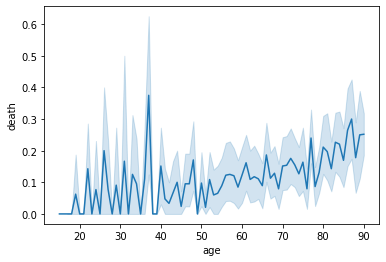

In [58]:
sns.lineplot(data=raw_df[raw_df.group=='train'], x="age", y="death")

<AxesSubplot:xlabel='age_trunc', ylabel='death'>

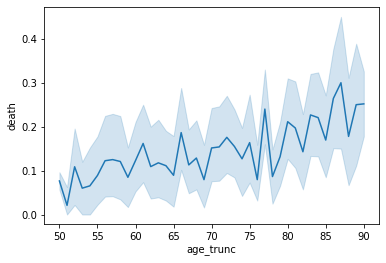

In [59]:
raw_df['age_trunc'] = raw_df['age'].clip(50,90)
sns.lineplot(data=raw_df[raw_df.group=='train'], x="age_trunc", y="death")

## gender
Gender is such a small difference it's likely not worth adding to the model

In [60]:
raw_df[raw_df.group=='train'].groupby('gender').agg({'death': ['mean','count']})

death      
            mean count
gender                
-1.0    0.000000     2
 0.0    0.141931  1388
 1.0    0.130387  1810

## icutype
There feature `icu_type` has a good split between the risk of death.  This will be added as a categorical variable to the model
1. Coronary Care Unit
1. Cardiac Surgery Recovery Unit
1. Medical ICU 
1. Surgical ICU

In [61]:
raw_df[raw_df.group=='train'].groupby('icutype').agg({'death': ['mean','count']})

death      
             mean count
icutype                
1.0      0.145652   460
2.0      0.037681   690
3.0      0.185430  1208
4.0      0.137767   842

In [62]:
raw_df['coronary'] = np.where(raw_df.icutype==1,1,0)
raw_df['cardiac'] = np.where(raw_df.icutype==2,1,0)
raw_df['medical'] = np.where(raw_df.icutype==3,1,0)
raw_df['surgical'] = np.where(raw_df.icutype==4,1,0)

## bun_delta_trunc
Reviewing the `bun` variable it appears the risk of death tops out around 60 before the values become become less reliant

<AxesSubplot:xlabel='bun_median_round', ylabel='death'>

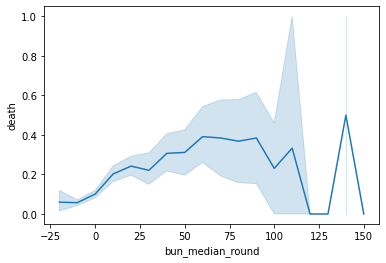

In [63]:
disp_df = raw_df.loc[raw_df.group=='train',['death','bun_delta_median']]
disp_df['bun_median_round'] = disp_df.bun_delta_median.round(-1)
sns.lineplot(data=disp_df, x="bun_median_round", y="death")
del disp_df

<AxesSubplot:xlabel='bun_delta_trunc', ylabel='death'>

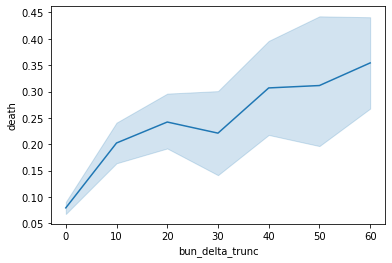

In [64]:
raw_df['bun_delta_trunc'] = raw_df['bun_delta_median'].clip(0,60)
disp_df = raw_df.loc[raw_df.group=='train',['death','bun_delta_trunc']]
disp_df['bun_delta_trunc'] = disp_df.bun_delta_trunc.round(-1)
sns.lineplot(data=disp_df, x="bun_delta_trunc", y="death")
del disp_df

## nidiasabp_delta_trunc
       

<AxesSubplot:xlabel='nidiasabp_delta_round', ylabel='death'>

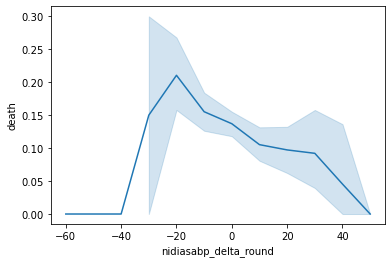

In [65]:
disp_df = raw_df.loc[raw_df.group=='train',['death','nidiasabp_delta_median']]
disp_df['nidiasabp_delta_round'] = disp_df.nidiasabp_delta_median.round(-1)
sns.lineplot(data=disp_df, x="nidiasabp_delta_round", y="death")
del disp_df

<AxesSubplot:xlabel='nidiasabp_delta_trunc', ylabel='death'>

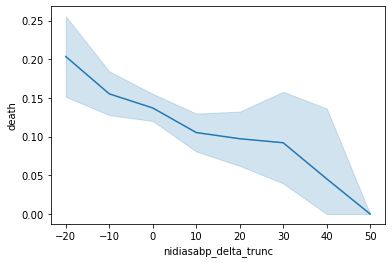

In [66]:
raw_df['nidiasabp_delta_trunc'] = raw_df['nidiasabp_delta_median'].clip(-20,50)
disp_df = raw_df.loc[raw_df.group=='train',['death','nidiasabp_delta_trunc']]
disp_df['nidiasabp_delta_trunc'] = disp_df.nidiasabp_delta_trunc.round(-1)
sns.lineplot(data=disp_df, x="nidiasabp_delta_trunc", y="death")
del disp_df

## temp_delta_trunc
The patients median temperature appears to be related to the risk of death specifically if the patient is colder.  This value from the median will be truncated at -1.5 and 0 as it appears to separate the data best.

<AxesSubplot:xlabel='temp_delta_round', ylabel='death'>

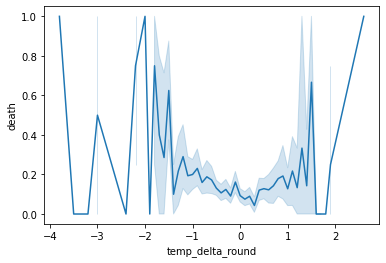

In [67]:
disp_df = raw_df.loc[raw_df.group=='train',['death','temp_delta_median']]
disp_df['temp_delta_round'] = disp_df.temp_delta_median.round(1)
sns.lineplot(data=disp_df, x="temp_delta_round", y="death")
del disp_df

<AxesSubplot:xlabel='temp_delta_trunc', ylabel='death'>

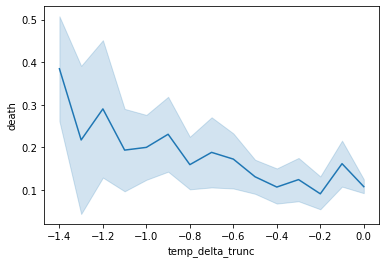

In [68]:
raw_df['temp_delta_trunc'] = raw_df['temp_delta_median'].clip(-1.4,0)
disp_df = raw_df.loc[raw_df.group=='train',['death','temp_delta_trunc']]
disp_df['temp_delta_trunc'] = disp_df.temp_delta_trunc.round(1)
sns.lineplot(data=disp_df, x="temp_delta_trunc", y="death")
del disp_df

## lactate_delta_trunc

<AxesSubplot:xlabel='lactate_delta_round', ylabel='death'>

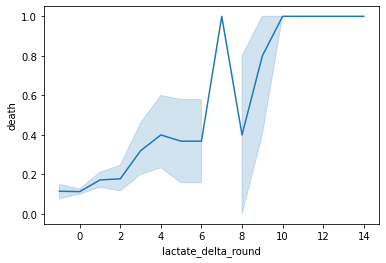

In [69]:
disp_df = raw_df.loc[raw_df.group=='train',['death','lactate_delta_median']]
disp_df['lactate_delta_round'] = disp_df.lactate_delta_median.round(0)
sns.lineplot(data=disp_df, x="lactate_delta_round", y="death")
del disp_df

<AxesSubplot:xlabel='lactate_delta_trunc', ylabel='death'>

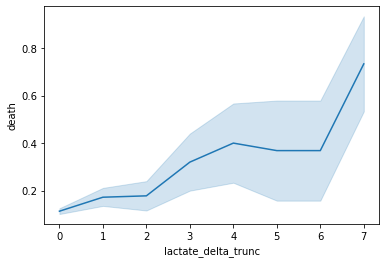

In [70]:
raw_df['lactate_delta_trunc'] = raw_df['lactate_delta_median'].clip(0,7)
disp_df = raw_df.loc[raw_df.group=='train',['death','lactate_delta_trunc']]
disp_df['lactate_delta_trunc'] = disp_df.lactate_delta_trunc.round(0)
sns.lineplot(data=disp_df, x="lactate_delta_trunc", y="death")
del disp_df

## gcs_day12_trunc

<AxesSubplot:xlabel='gcs_day12_round', ylabel='death'>

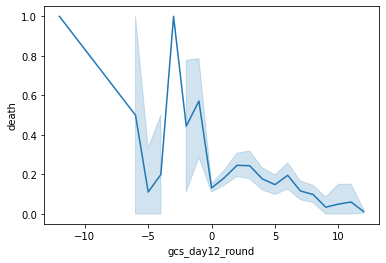

In [71]:
disp_df = raw_df.loc[raw_df.group=='train',['death','gcs_day12_delta']]
disp_df['gcs_day12_round'] = disp_df.gcs_day12_delta
sns.lineplot(data=disp_df, x="gcs_day12_round", y="death")
del disp_df

<AxesSubplot:xlabel='gcs_day12_trunc', ylabel='death'>

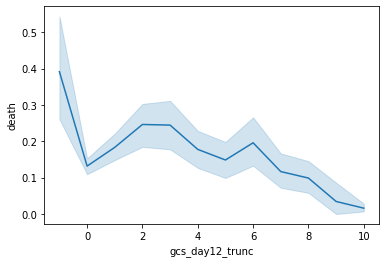

In [72]:
raw_df['gcs_day12_trunc'] = raw_df['gcs_day12_delta'].clip(-1,10)
disp_df = raw_df.loc[raw_df.group=='train',['death','gcs_day12_trunc']]
disp_df['gcs_day12_trunc'] = disp_df.gcs_day12_trunc.round(0)
sns.lineplot(data=disp_df, x="gcs_day12_trunc", y="death")
del disp_df

# Develop Models

## Regression
A regression model was developed based on the [towardsdatasciece](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a) tutorial.

All plots come from [sklearn](https://scikit-learn.org/stable/visualizations.html)

### Data

In [73]:
# Review the columns and decide what to add to the training data
raw_df.columns

Index(['death', 'group', 'age', 'gender', 'height', 'icutype', 'has_albumin',
       'has_alt', 'has_gcs', 'has_paco2', 'has_resprate', 'has_troponini',
       'has_troponint', 'bun_delta_median', 'lactate_delta_median',
       'nidiasabp_delta_median', 'temp_delta_median', 'gcs_day12_delta',
       'age_trunc', 'coronary', 'cardiac', 'medical', 'surgical',
       'bun_delta_trunc', 'nidiasabp_delta_trunc', 'temp_delta_trunc',
       'lactate_delta_trunc', 'gcs_day12_trunc'],
      dtype='object')

In [74]:
# Split out the training data, and identify features

feature_list = ['cardiac', 'coronary','age_trunc',
       'has_alt', 'has_paco2', 'has_resprate', 'has_troponini',
       'bun_delta_trunc','temp_delta_trunc','lactate_delta_trunc', 'gcs_day12_trunc']

# Training Population
train_pop = raw_df.group == 'train'
x_train = raw_df.loc[train_pop, feature_list]
x_train = sm.add_constant(x_train)
y_train = raw_df.loc[train_pop,'death']

# Testing Population
test_pop = raw_df.group =='test'
x_test = raw_df.loc[test_pop, feature_list]
x_test = sm.add_constant(x_test)
y_test = raw_df.loc[test_pop,'death']

### Run Model
Perform logistic regression model and save predictions as `y_train_proba` to for future summary statistics.

In [75]:
log_reg = sm.Logit(y_train, x_train).fit()
y_train_proba = log_reg.predict(x_train)

Optimization terminated successfully.
         Current function value: 0.314701
         Iterations 8


### Summary
Reveiw the summary of the logistic regression.

In [76]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                 3200
Model:                          Logit   Df Residuals:                     3188
Method:                           MLE   Df Model:                           11
Date:                Sun, 09 Oct 2022   Pseudo R-squ.:                  0.2060
Time:                        12:26:55   Log-Likelihood:                -1007.0
converged:                       True   LL-Null:                       -1268.4
Covariance Type:            nonrobust   LLR p-value:                4.769e-105
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.7672      0.374    -12.741      0.000      -5.501      -4.034
cardiac                -1.3968      0.230     -6.078      0.000      -1.847      -0.946
coronary        

### ROC
Calcuate the receiving operator curve

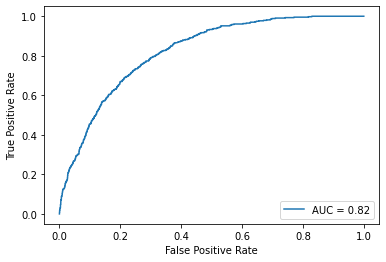

In [77]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_proba)
roc_auc = metrics.auc(fpr, tpr)
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

### Calibration
Review the calibration 

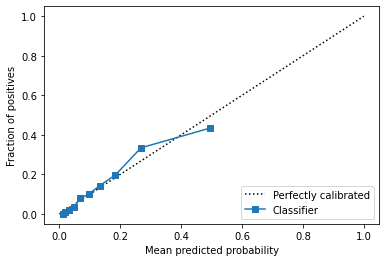

In [78]:
CalibrationDisplay.from_predictions(y_train, y_train_proba, n_bins=10, strategy = 'quantile')

### Precision/Recall

In [79]:
y_train_class = y_train_proba > .25
print(metrics.classification_report(y_train, y_train_class, target_names=['Survive','Death']))

              precision    recall  f1-score   support

     Survive       0.92      0.89      0.90      2767
       Death       0.40      0.49      0.44       433

    accuracy                           0.83      3200
   macro avg       0.66      0.69      0.67      3200
weighted avg       0.85      0.83      0.84      3200



### Confusion Matrix

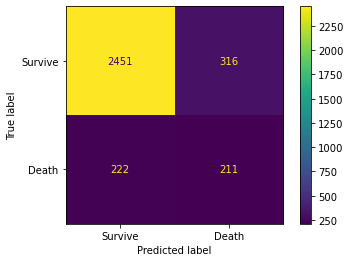

In [80]:
cm = metrics.confusion_matrix(y_train, y_train_class)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Survive','Death']).plot()

# Validate Models

## Score Model

In [81]:
# Split out the training data, and identify features
y_test_proba = log_reg.predict(x_test)

## ROC

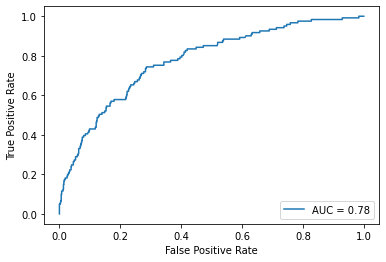

In [82]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_proba)
roc_auc = metrics.auc(fpr, tpr)
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

## Calibration

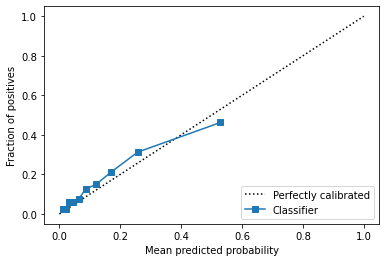

In [83]:
CalibrationDisplay.from_predictions(y_test, y_test_proba, n_bins=10, strategy = 'quantile')

## Precision/Recall

In [84]:
y_test_class = y_test_proba > .25
print(metrics.classification_report(y_test, y_test_class, target_names=['Survive','Death']))

              precision    recall  f1-score   support

     Survive       0.90      0.90      0.90       679
       Death       0.43      0.43      0.43       121

    accuracy                           0.83       800
   macro avg       0.66      0.66      0.66       800
weighted avg       0.83      0.83      0.83       800



## Confusion Matrix

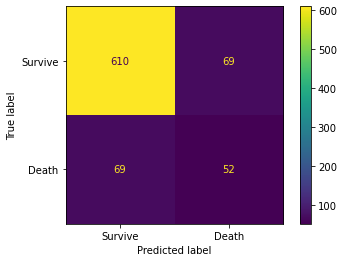

In [85]:
cm = metrics.confusion_matrix(y_test, y_test_class)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Survive','Death']).plot()